In [3]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from windrose import WindroseAxes
import matplotlib.cm as cm
import plotly.express as px
import math
import os, importlib, sys

sys.path.insert(0, '../../code/src')
#importlib.reload(sys.modules['pmf_result'])
from pmf_result import pmf_output_to_df
from pmf_result import plot_pmf_profile
from pmf_result import plot_factor_time_series
from pmf_result import reorder_factor

In [73]:
# extract PMF output
profile_conc, profile_perc_spec, profile_perc_factor, contribution = \
    pmf_output_to_df(43,9,'../../data/intermediate/PMF_output/Factor9')
new_order = ['Factor 7','Factor 1','Factor 4','Factor 9','Factor 6','Factor 5','Factor 2',
             'Factor 8','Factor 3']
#new_order = ['Factor 1','Factor 5','Factor 2','Factor 8','Factor 4','Factor 3','Factor 7',
#             'Factor 6','Factor 9']
profile_perc_spec = reorder_factor(profile_perc_spec, new_order)
profile_conc = reorder_factor(profile_conc, new_order)
contribution = reorder_factor(contribution, new_order)

# rename factor name in column
factor_name = ['Composting(MeOH)', 'Biogenic', 'Gasoline vapor-summer blend',
               'Gasoline vapor-winter vapor', 'Secondary VOC + halogenated VOC',
               'University + k12 institutes', 'Anthoropogenic solvents', 
               'VCP(siloxane)','VCP(ethanol)']
profile_conc.columns = ['Parameter'] + factor_name
contribution.columns = ['Date'] + factor_name

# save files
profile_conc.to_csv('../../data/final/pmf_profile_conc.csv', index=False)
contribution.to_csv('../../data/final/pmf_profile_perc_spec.csv', index=False)

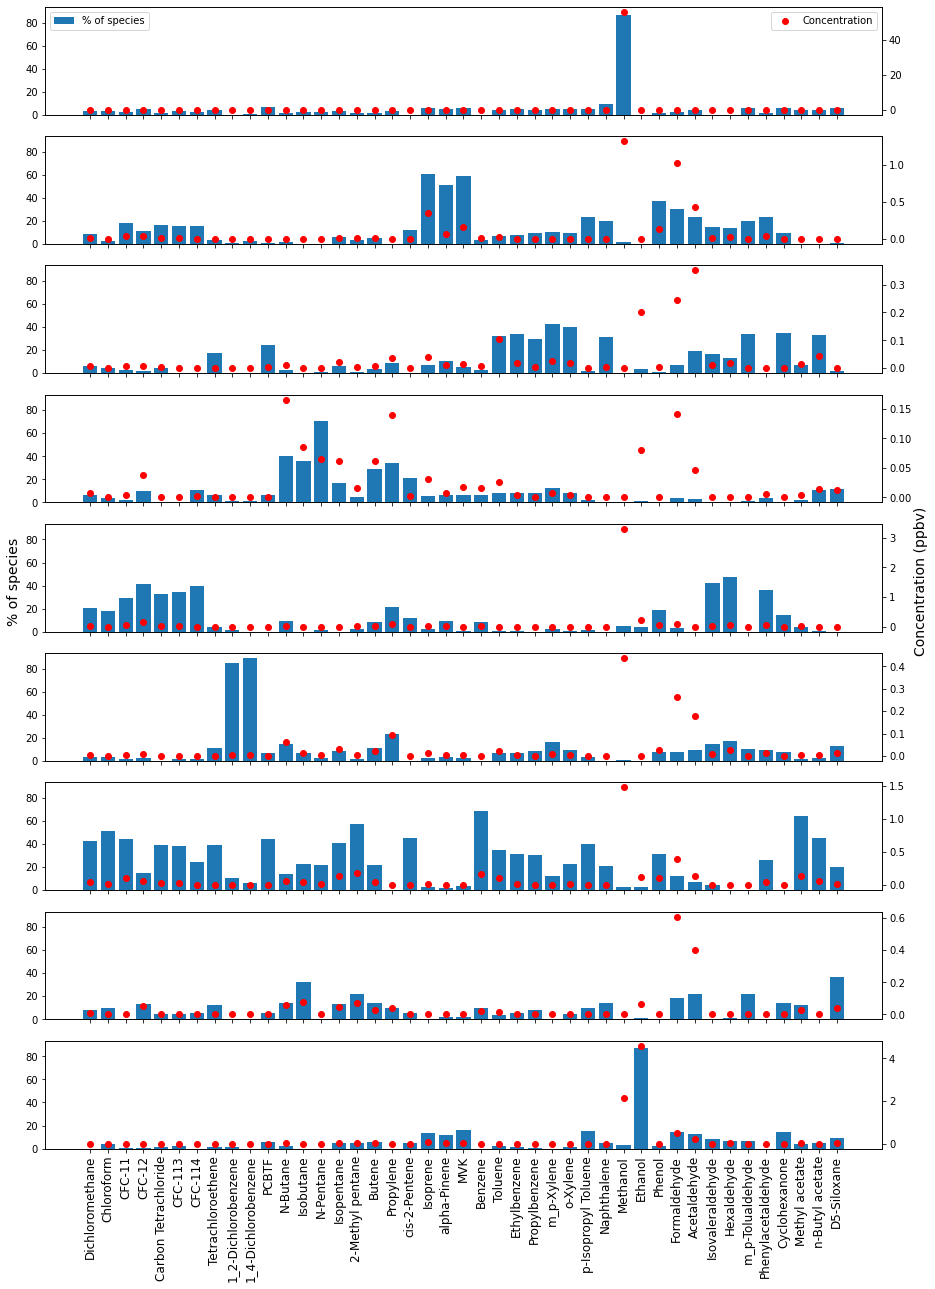

In [47]:
fig = plot_pmf_profile(43,9,profile_perc_spec,profile_conc)

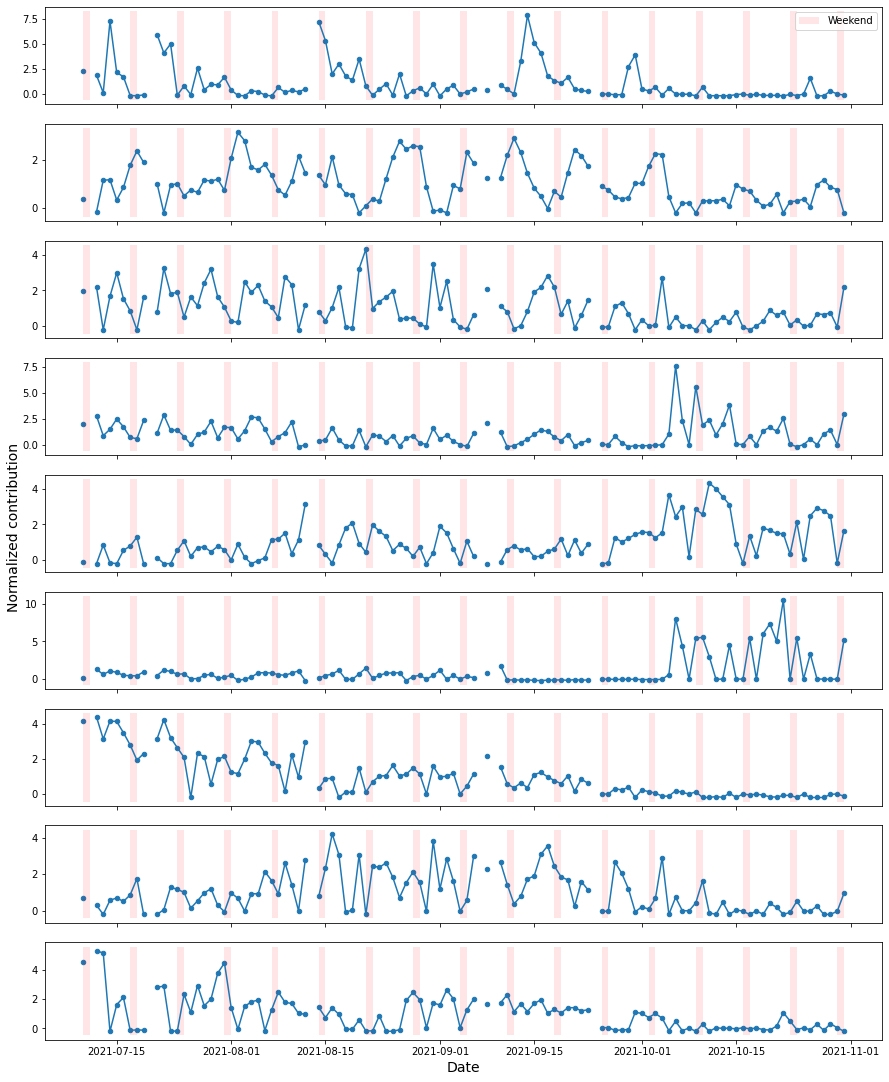

In [32]:
fig = plot_factor_time_series(43,9,contribution)

Calculate MIR or VOCR of PMF-solved factors

In [50]:
df_reactivity=pd.read_csv('../../data/raw/VOC_reactivity_MIR_redlands.csv')
df_reactivity['Parameter'] = df_reactivity['Parameter'].str.replace(',','_')
df_reactivity.loc[df_reactivity['Parameter'].str.contains('Decamethylcyclopentasiloxane'),'Parameter'] = 'D5-Siloxane'
df_reactivity = df_reactivity.replace('Trichlorofluoromethane','CFC-11')
df_reactivity = df_reactivity.replace('Dichlorodifluoromethane','CFC-12')
df_reactivity = df_reactivity.replace('1_1_2-Trichlorotrifluoroethane','CFC-113')
df_reactivity = df_reactivity.replace('1_2-Dichloro-1_1_2_2-tetrafluoroethane','CFC-114')

# get MIR list
df_MIR = profile_conc.merge(df_reactivity[['Parameter','MW','MIR']], 
                            on='Parameter', how='left')[['Parameter','MW','MIR']]
# get OH reactivity list
df_OH_reactivity = df_reactivity[['Parameter','MW','A','B','E/R(K-1)','Ea(J/mol)','k(T)','T']]

In [51]:
# replace alpha-pinene by TERP concentration used in box model
index_alpha_pinene = profile_conc[profile_conc['Parameter']=='alpha-Pinene'].index[0]
profile_conc.iloc[index_alpha_pinene,1:10] = \
    profile_conc.iloc[index_alpha_pinene,1:10]/0.112459

In [70]:
# calculate MIR for each factor
profile_MIR = profile_conc.merge(df_MIR, on='Parameter', how='left')

# calculate OFP=MIR*[VOC]*MW(VOC)/MW(O3)
for i in profile_MIR.columns[1:10]:
    column_name = 'MIR_' + i
    profile_MIR[column_name] = profile_MIR[i]*profile_MIR['MW']*profile_MIR['MIR']/48
PMF_factor_MIR = profile_MIR.iloc[:,12:]

# sum OFP for each factor
OFP_factor = pd.DataFrame(PMF_factor_MIR.sum(axis=0))
OFP_factor.columns = ['OFP']
OFP_factor['OFP_prec'] = OFP_factor['OFP']/OFP_factor['OFP'].sum()*100

([<matplotlib.patches.Wedge at 0x27e7e27e5b0>,
 [Text(0.7955373543603234, 0.7596843540690946, 'Composting(MeOH)'),
  Text(-0.7025798271185371, 0.8463932812387435, 'Biogenic'),
  Text(-1.0933142189653853, -0.12109508085843085, 'Gasoline vapor-summer blend'),
  Text(-0.9577358955012364, -0.5410563320657518, 'Gasoline vapor-winter vapor'),
  Text(-0.7200320410207344, -0.8315971740593614, 'Secondary VOC + halogenated VOC'),
  Text(-0.3906100136428018, -1.0283111480685068, 'University + k12 institutes'),
  Text(0.04253988539298713, -1.0991771277418174, 'Anthoropogenic solvents'),
  Text(0.5145932526481739, -0.9722107715557223, 'VCP(siloxane)'),
  Text(0.996315557669163, -0.4662138023979822, 'VCP(ethanol)')],
 [Text(0.43392946601472177, 0.4143732840376879, '24.3%'),
  Text(-0.3832253602464747, 0.46166906249386, '23.5%'),
  Text(-0.5963532103447555, -0.06605186228641682, '7.9%'),
  Text(-0.5224013975461289, -0.2951216356722282, '4.9%'),
  Text(-0.39274474964767325, -0.45359845857783343, '6.0%

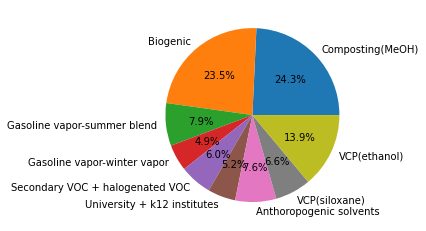

In [72]:
fig, ax=plt.subplots(1)
ax.pie(OFP_factor['OFP_prec'], labels=factor_name, autopct='%.1f%%')